# Commodities Project
Kylian Yamami, Mathis Rais, Tommy Ribeiro

This project was carried out as part of the Commodities Markets and Models course taught by Mr. LOUKILI Mehdi in 4th year in the Financial Engineering major at ESILV during the 2024-2025 academic year.

Our objective is to create an investment strategy focused on commodities. The strategy takes the form of an index that invests in single-commodity indices by taking long and/or short positions.

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
# List of commodities with their associated file names
tickers_files = {
    "Aluminum": r"Data\Data daily\Bloomberg Aluminum - Historical data.csv",
    "Brent Crude": r"Data\Data Daily\Bloomberg Brent Crude - Historical data.csv",
    "Coffee": r"Data\Data daily\Bloomberg Coffee - Historical data.csv",
    "Copper": r"Data\Data daily\Bloomberg Copper - Historical data.csv",
    "Corn": r"Data\Data daily\Bloomberg Corn - Historical data.csv",
    "Cotton": r"Data\Data daily\Bloomberg Cotton - Historical data.csv",
    "Gold": r"Data\Data daily\Bloomberg Gold - Historical data.csv",
    "Lean Hogs": r"Data\Data daily\Bloomberg Lean Hogs - Historical data.csv",
    "Petroleum": r"Data\Data Daily\Bloomberg Petroleum - Historical data.csv",
    "Silver": r"Data\Data daily\Bloomberg Silver - Historical data.csv",
    "Soybeans": r"Data\Data daily\Bloomberg Soybeans - Historical data.csv",
    "Sugar": r"Data\Data daily\Bloomberg Sugar - Historical data.csv",
    "Wheat": r"Data\Data daily\Bloomberg Wheat - Historical data.csv",
    "WTI Crude Oil": r"Data\Data daily\Bloomberg WTI Crude Oil - Historical data.csv",   
}

# Dictionary to store the DataFrames
dataframes = {}

# Import the files
for ticker, file in tickers_files.items():
    df = pd.read_csv(file)
    dataframes[ticker] = df

# Check successful import
for ticker, df in dataframes.items():
    print(f"--- DataFrame for {ticker} ---")
    print(df.head(2))

--- DataFrame for Aluminum ---
         Date  Dernier     Ouv.  Plus Haut Plus Bas  Vol. Variation %
0  08/11/2024  32,1511  33,1828    33,2290  32,0999   NaN      -2,77%
1  07/11/2024  33,0657  32,3429    33,4966  32,3091   NaN       3,03%
--- DataFrame for Brent Crude ---
         Date Dernier    Ouv.  Plus Haut Plus Bas  Vol. Variation %
0  12/11/2024  456,15  455,30     462,00   454,41   NaN       0,00%
1  11/11/2024  456,15  467,52     470,18   454,77   NaN      -2,69%
--- DataFrame for Coffee ---
         Date  Dernier     Ouv.  Plus Haut Plus Bas  Vol. Variation %
0  31/10/2024  17,0944  17,3516    17,3516  16,9867   NaN      -1,48%
1  30/10/2024  17,3516  17,2474    17,4177  17,0458   NaN       0,60%
--- DataFrame for Copper ---
         Date Dernier    Ouv.  Plus Haut Plus Bas  Vol. Variation %
0  31/10/2024  371,56  372,54     374,94   370,40   NaN      -0,26%
1  30/10/2024  372,54  374,51     375,28   370,32   NaN      -0,21%
--- DataFrame for Corn ---
         Date Dernier 

In [16]:
prices = pd.DataFrame()
returns = pd.DataFrame()

for ticker, df in dataframes.items():
    df = df.rename(columns={"Dernier": "Price"})
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce', dayfirst=True)

    df = df.sort_values('Date').reset_index()

    df["Price"] = df["Price"].str.replace(",", ".")
    df["Price"] = pd.to_numeric(df["Price"], errors='coerce')

    df["Returns"] = df["Price"].pct_change(fill_method=None)

    df = df[["Date", "Price", "Returns"]]

    df.set_index('Date', inplace=True)

    dataframes[ticker] = df

    # Filter for dates greater than 2023
    df = df.loc[(df.index > '2023-01-01') & (df.index < '2024-10-31')]

    prices[ticker] = df['Price']
    returns[ticker] = df['Returns']

    print(f"--- {ticker} ---")
    print(df.head(2))

--- Aluminum ---
              Price   Returns
Date                         
2023-01-03  32.1482 -0.029515
2023-01-04  31.5407 -0.018897
--- Brent Crude ---
             Price   Returns
Date                        
2023-01-03  465.61 -0.044354
2023-01-04  441.45 -0.051889
--- Coffee ---
              Price   Returns
Date                         
2023-01-03  10.4708 -0.005981
2023-01-04  10.1560 -0.030065
--- Copper ---
             Price   Returns
Date                        
2023-01-03  337.73 -0.011561
2023-01-04  335.40 -0.006899
--- Corn ---
              Price   Returns
Date                         
2023-01-03  13.5017 -0.011791
2023-01-04  13.1644 -0.024982
--- Cotton ---
              Price   Returns
Date                         
2023-01-03  30.3564 -0.002759
2023-01-04  29.3705 -0.032478
--- Gold ---
             Price   Returns
Date                        
2023-01-03  197.92  0.010879
2023-01-04  199.30  0.006973
--- Lean Hogs ---
             Price   Returns
Date             

We noticed that some data rows were missing for ```Brent Crude```, which distorted our curves.  
Therefore, we decided to interpolate this column to replace the missing values.

In [4]:
prices["Brent Crude"] = prices["Brent Crude"].interpolate()

Below is the correlation matrix of our commodity prices. This visualization provides insight into the relationships that exist between our assets.

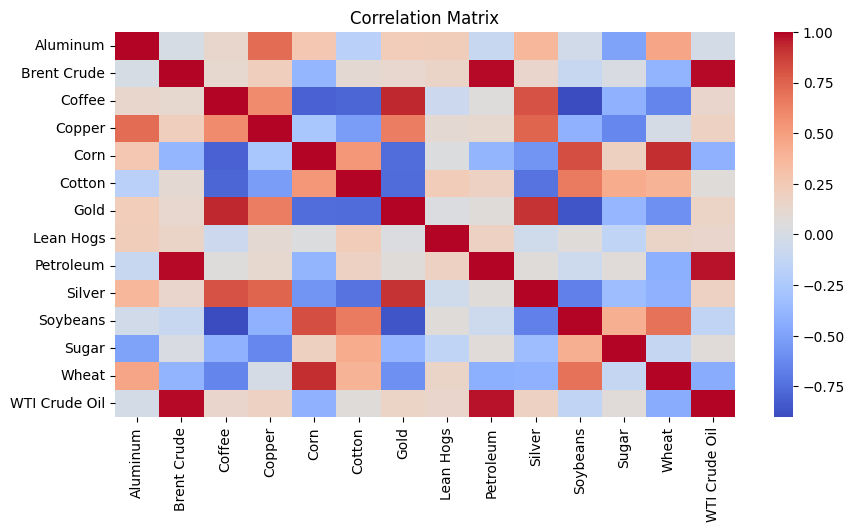

In [5]:
corr = prices.corr()
plt.figure(figsize=(10, 5))
sns.heatmap(corr, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [6]:
lookback = 20               # window for past performance calculation
rebalance_freq = 20         # rebalancing frequency (in business days)
n_long_short = 6            # number of long and short positions

index_values = []
weights_history = []
rebalance_dates = []
initial_index_value = 100
index_values.append(initial_index_value)

# Main loop to build the index
for i in range(lookback, len(prices)):
    today = prices.index[i]
    rebalance = ((i - lookback) % rebalance_freq == 0)

    if rebalance:
        perf = (prices.iloc[i - lookback:i].pct_change() + 1).prod() - 1
        ranked = perf.sort_values()
        longs = ranked.head(n_long_short).index.tolist()
        shorts = ranked.tail(n_long_short).index.tolist()

        weights = {c: 0 for c in prices.columns}
        for c in longs:
            weights[c] = 1 / n_long_short
        for c in shorts:
            weights[c] = -1 / n_long_short

        rebalance_UI = prices.loc[today].copy()
        rebalance_weights = weights.copy()
        rebalance_dates.append(today)

    curr_UI = prices.iloc[i]
    ER_t = index_values[-1] + sum(
        rebalance_weights[c] * ((curr_UI[c] / rebalance_UI[c]) - 1)
        for c in prices.columns
    ) * index_values[-1]

    index_values.append(ER_t)
    weights_history.append(rebalance_weights.copy())

In [7]:
# Final time series of the index
index_dates = prices.index[lookback:]
index_series = pd.Series(index=index_dates, data=index_values[1:])
nbr_years = round((index_dates[-1] - index_dates[0]).days / 365)

# Performance metrics
returns = index_series.pct_change().dropna()
cumulative_return = index_series.iloc[-1] / index_series.iloc[0] - 1
volatility = returns.std() * np.sqrt(252)
sharpe_ratio = (cumulative_return / nbr_years) / volatility
max_drawdown = ((index_series / index_series.cummax()) - 1).min()

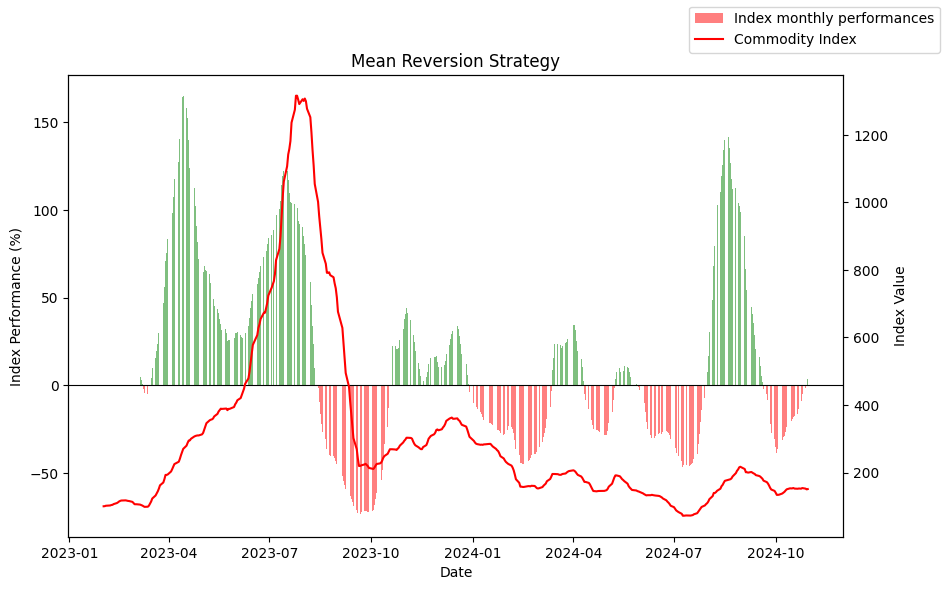

In [8]:
# Calculation of performances
perf = index_series.pct_change(22) * 100

# Colors for performances: green if positive, red if negative
colors = ['green' if val > 0 else 'red' for val in perf]

fig, ax1 = plt.subplots(figsize=(10, 6))

# Performances in %
ax1.bar(index_series.index, perf, color=colors, alpha=0.5, label='Index monthly performances')
ax1.set_xlabel('Date')
ax1.set_ylabel('Index Performance (%)')
ax1.axhline(0, color='black', linewidth=0.8)  # Horizontal line at 0

# Second axis for the index curve
ax2 = ax1.twinx()
ax2.plot(index_series, color='red', label='Commodity Index')
ax2.set_ylabel('Index Value')

fig.legend()

plt.title('Mean Reversion Strategy')

plt.show()

During July 2023, we observe a clear spike that can be intuitively explained from a financial perspective: this period coincides with the barbecue season. Thanks to the plot of the portfolio weights (see last graph), we see strong buying pressure on lean hogs, which leads our mean-reversion strategy to take a short position on this asset (anticipating that its price will revert to its long-term average).

However, we do not observe the same dynamic in July 2024. After researching the macroeconomic context, we found that China significantly reduced its imports of lean hogs in 2024, which could explain this decline.

Finally, regarding wheat, during harvest periods, we expect increased buying pressure, which is indeed reflected in our portfolio weights plot (see last graph). Our strategy shorts this asset, anticipating a mean reversion after the price increase caused by the harvest.

In [9]:
# Display of indicators
metrics = pd.DataFrame({
    "Cumulative Return": [f"{cumulative_return:.2%}"],
    "Annualized Volatility": [f"{volatility:.2%}"],
    "Sharpe Ratio": [f"{sharpe_ratio:.2f}"],
    "Max Drawdown": [f"{max_drawdown:.2%}"]
})

print(metrics)

  Cumulative Return Annualized Volatility Sharpe Ratio Max Drawdown
0            50.92%                49.84%         0.51      -94.53%


In [10]:
# Retrieve the historical weights as a dataframe
weights_df = pd.DataFrame.from_dict(weights_history)
weights_df.index = index_dates
weights_df

,Aluminum,Brent Crude,Coffee,Copper,Corn,Cotton,Gold,Lean Hogs,Petroleum,Silver,Soybeans,Sugar,Wheat,WTI Crude Oil
Date,,,,,,,,,,,,,,
2023-02-01,-0.166667,0.000000,-0.166667,-0.166667,0.166667,0.000000,-0.166667,0.166667,-0.166667,0.166667,0.166667,-0.166667,0.166667,0.166667
2023-02-02,-0.166667,0.000000,-0.166667,-0.166667,0.166667,0.000000,-0.166667,0.166667,-0.166667,0.166667,0.166667,-0.166667,0.166667,0.166667
2023-02-03,-0.166667,0.000000,-0.166667,-0.166667,0.166667,0.000000,-0.166667,0.166667,-0.166667,0.166667,0.166667,-0.166667,0.166667,0.166667
2023-02-06,-0.166667,0.000000,-0.166667,-0.166667,0.166667,0.000000,-0.166667,0.166667,-0.166667,0.166667,0.166667,-0.166667,0.166667,0.166667
2023-02-07,-0.166667,0.000000,-0.166667,-0.166667,0.166667,0.000000,-0.166667,0.166667,-0.166667,0.166667,0.166667,-0.166667,0.166667,0.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-24,-0.166667,0.166667,0.000000,-0.166667,0.000000,-0.166667,0.166667,0.166667,0.166667,-0.166667,0.166667,-0.166667,-0.166667,0.166667
2024-10-25,-0.166667,0.166667,0.000000,-0.166667,0.000000,-0.166667,0.166667,0.166667,0.166667,-0.166667,0.166667,-0.166667,-0.166667,0.166667
2024-10-28,-0.166667,0.166667,0.000000,-0.166667,0.000000,-0.166667,0.166667,0.166667,0.166667,-0.166667,0.166667,-0.166667,-0.166667,0.166667


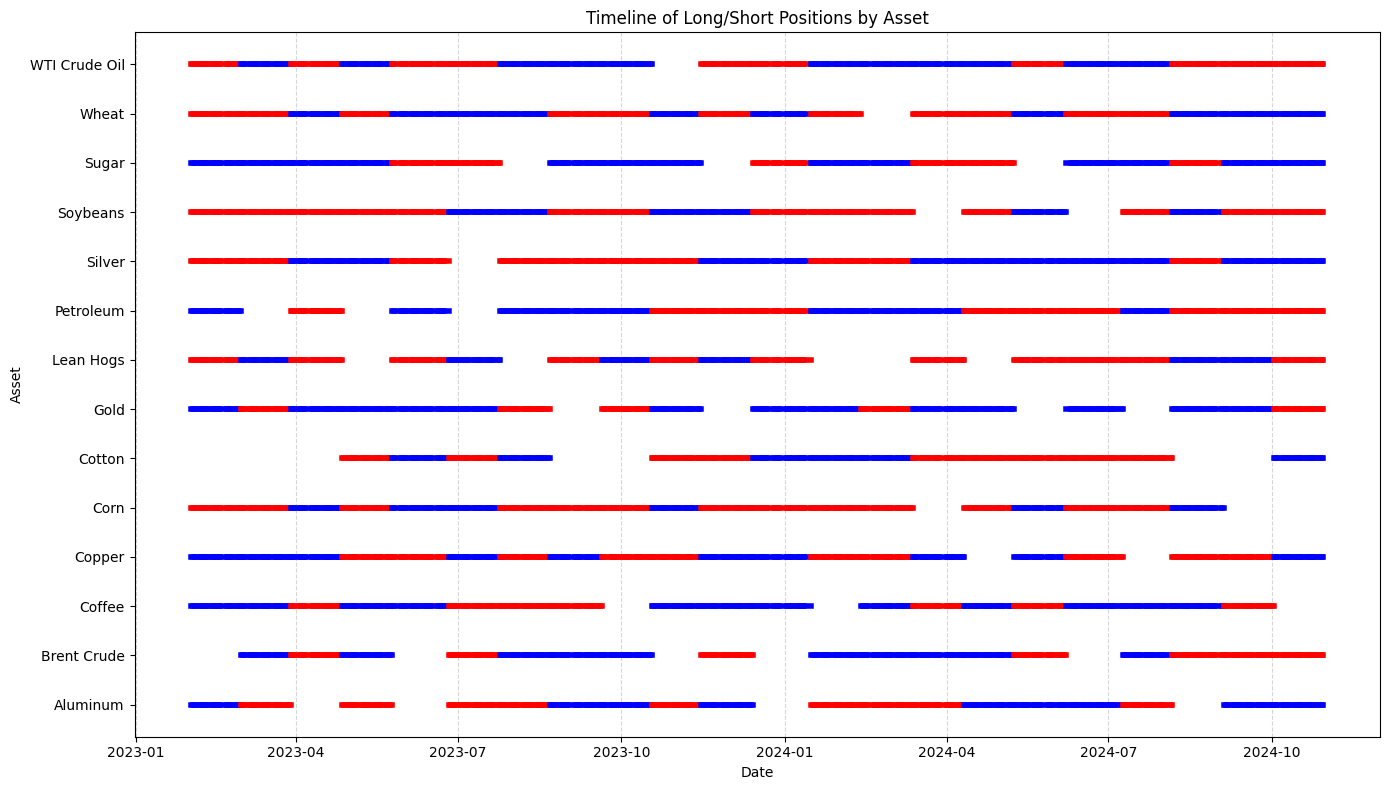

In [11]:
# Plot of the variation of weights over time
fig, ax = plt.subplots(figsize=(14, 8))

for i, ticker in enumerate(weights_df.columns):
    pos_series = weights_df[ticker]
    dates = pos_series.index

    # Colors: long (red), short (blue)
    for j in range(1, len(dates)):
        val = pos_series.iloc[j]
        if val > 0:
            ax.plot(dates[j-1:j+1], [i, i], color='red', linewidth=4)
        elif val < 0:
            ax.plot(dates[j-1:j+1], [i, i], color='blue', linewidth=4)

ax.set_yticks(range(len(weights_df.columns)))
ax.set_yticklabels(weights_df.columns)
ax.set_title("Timeline of Long/Short Positions by Asset")
ax.set_xlabel("Date")
ax.set_ylabel("Asset")
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()